# Proyecto: Predicción de cancelación de clientes (Churn) en Interconnect
**Por María Payró González**


In [8]:
# Carga de Librerías

# Análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

# Balanceo de clases
from imblearn.over_sampling import SMOTE

## Preparación de datos

In [9]:
# Carga de los datos

path = "/datasets/"  # ruta del dataset desde mi computadora

contract = pd.read_csv(path + "contract.csv")
personal = pd.read_csv(path + "personal.csv")
internet = pd.read_csv(path + "internet.csv")
phone = pd.read_csv(path + "phone.csv")

# Merge de los dataframes en uno usando 'customerID' 
df = pd.merge(contract, personal, on='customerID', how='outer')
df = pd.merge(df, internet, on='customerID', how='outer')
df = pd.merge(df, phone, on='customerID', how='outer')

print("Datos cargados y unidos correctamente.")
df.head()

Datos cargados y unidos correctamente.


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,593.3,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,542.4,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes
2,0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.9,280.85,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
3,0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.0,1237.85,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
4,0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.9,267.4,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No


In [20]:
# Preparación Inicial de Datos 

# 1. Se crea la variable objetivo 'Churn' (1 si el cliente se fue, 0 si no)
df['Churn'] = (df['EndDate'] != 'No').astype(int)

# 2. Se convierte 'TotalCharges' a tipo de dato numérico.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 3. Se rellenan los valores nulos en 'TotalCharges' con 0.
df['TotalCharges'].fillna(0, inplace=True)

# 4. Se eliminan aquellas columnas que ya no serán necesarias para el desarrollo de los modelos.
df_model = df.drop(columns=['customerID', 'BeginDate', 'EndDate'])

print("Df con valores nulos:")
df_model.info()
print("\n")

# Se rellenan los valores nulos

# Lista de columnas categóricas a rellenar
cols_to_fill = [
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
]

# Rellenar los valores nulos con la cadena 'No service'
for col in cols_to_fill:
    df_model[col].fillna('No service', inplace=True)

print("Df sin valores nulos:")
df_model.info()

print("\n")
print("Preparación inicial de datos completada.")

Df con valores nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   5517 non-null   object 
 10  OnlineSecurity    5517 non-null   object 
 11  OnlineBackup      5517 non-null   object 
 12  DeviceProtection  5517 non-null   object 
 13  TechSupport       5517 non-null   object 
 14  StreamingTV       5517 non-null   object 
 15  StreamingMovies   5517 non-null   object 
 16  MultipleLines     63

/var/folders/8b/k94vkkr16vl13_n7nv3zfv7h0000gn/T/ipykernel_35781/3695820180.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)
/var/folders/8b/k94vkkr16vl13_n7nv3zfv7h0000gn/T/ipykernel_35781/3695820180.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

## EDA

Clientes que se quedaron: 5174 (73.46%)
Clientes que se fueron (Churn): 1869 (26.54%)


/var/folders/8b/k94vkkr16vl13_n7nv3zfv7h0000gn/T/ipykernel_35781/3672587245.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df_model, palette='viridis')


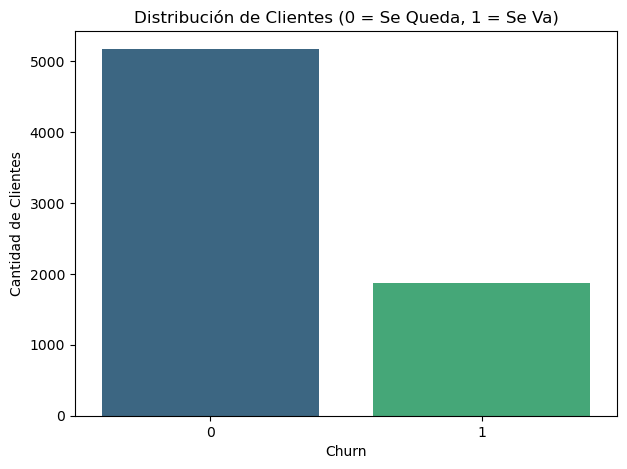

In [22]:
# EDA - Análisis de la Variable Objetivo (Churn)

plt.figure(figsize=(7, 5))
sns.countplot(x='Churn', data=df_model, palette='viridis')
plt.title('Distribución de Clientes (0 = Se Queda, 1 = Se Va)')
plt.xlabel('Churn')
plt.ylabel('Cantidad de Clientes')

# Calcular y mostrar el porcentaje
total = len(df_model)
churn_count = df_model['Churn'].sum()
no_churn_count = total - churn_count
print(f"Clientes que se quedaron: {no_churn_count} ({no_churn_count/total:.2%})")
print(f"Clientes que se fueron (Churn): {churn_count} ({churn_count/total:.2%})")

plt.show()

En esta parte se puede ver que hay un claro desbalance, donde la mayoría de los clientes (casi el 74%) no se han ido.

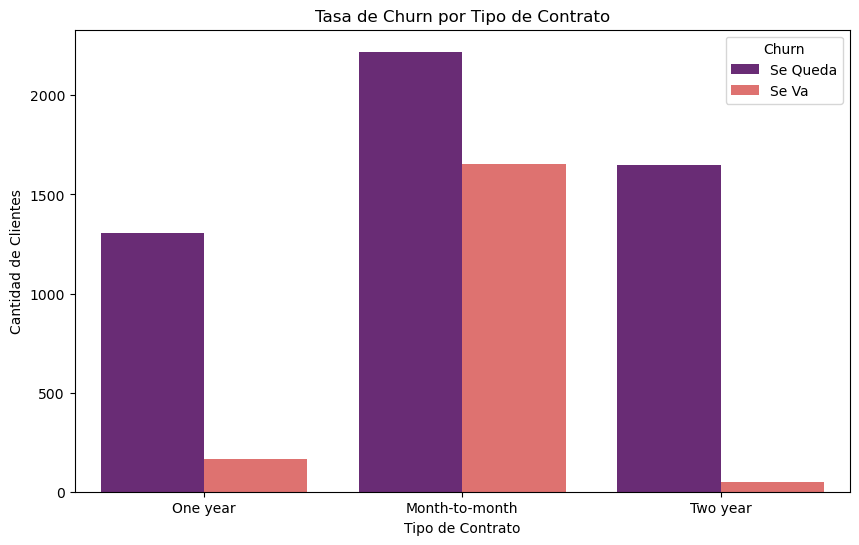

In [24]:
# EDA - Churn vs. Tipo de Contrato

plt.figure(figsize=(10, 6))
sns.countplot(x='Type', hue='Churn', data=df_model, palette='magma')
plt.title('Tasa de Churn por Tipo de Contrato')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Cantidad de Clientes')
plt.legend(title='Churn', labels=['Se Queda', 'Se Va'])
plt.show()

Se observa que aquellos clientes con contrato mensual (month-to-month) tienen una tasa de cancelación muchísimo más alta que los clientes con contratos de 1 o 2 años.

/var/folders/8b/k94vkkr16vl13_n7nv3zfv7h0000gn/T/ipykernel_35781/441738426.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='MonthlyCharges', data=df_model, palette='viridis')


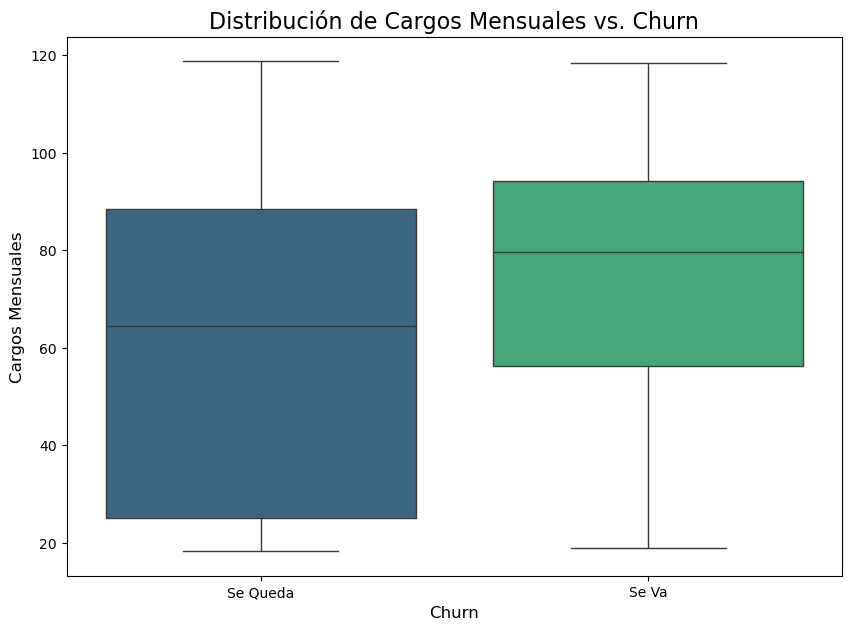

In [26]:
# --- Celda EDA: Churn vs. Cargos Mensuales ---

plt.figure(figsize=(10, 7))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df_model, palette='viridis')
plt.title('Distribución de Cargos Mensuales vs. Churn', fontsize=16)
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Cargos Mensuales', fontsize=12)
plt.xticks([0, 1], ['Se Queda', 'Se Va']) # Etiqueta más clara para el eje x
plt.show()

La caja correspondiente verde a los clientes que se fueron (Churn = 1) está más arriba, lo cual indica que, en general, los clientes que pagan más al mes tienden a cancelar el servicio con mayor frecuencia.

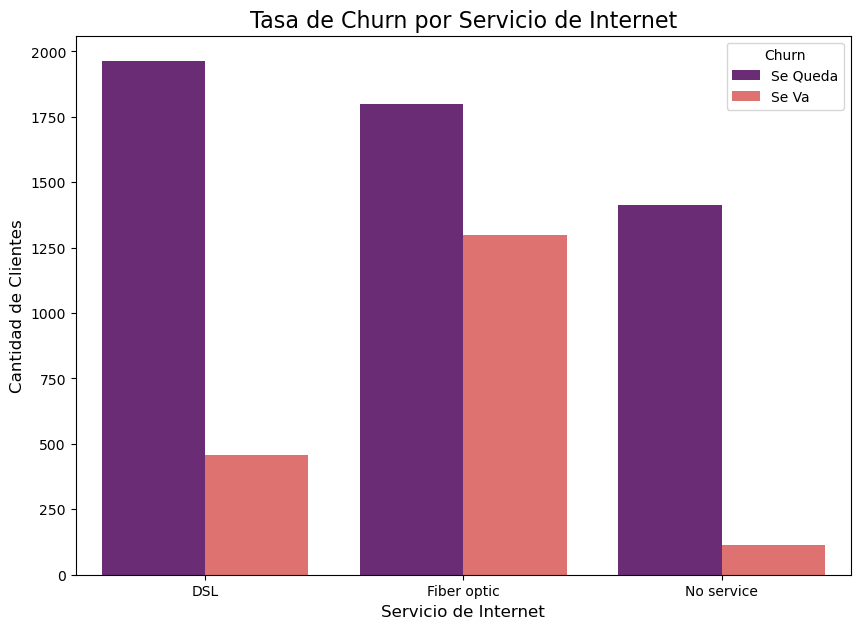

In [29]:
# --- Celda EDA: Churn vs. Servicio de Internet ---

plt.figure(figsize=(10, 7))
sns.countplot(x='InternetService', hue='Churn', data=df_model, palette='magma')
plt.title('Tasa de Churn por Servicio de Internet', fontsize=16)
plt.xlabel('Servicio de Internet', fontsize=12)
plt.ylabel('Cantidad de Clientes', fontsize=12)
plt.legend(title='Churn', labels=['Se Queda', 'Se Va'])
plt.show()

Generalmente, los clientes con Fibra Óptica (Fiber optic) tienen una tasa de churn mucho más alta. Esto puede deberse a precios más elevados, mayor competencia en ese segmento o problemas de estabilidad inicial.

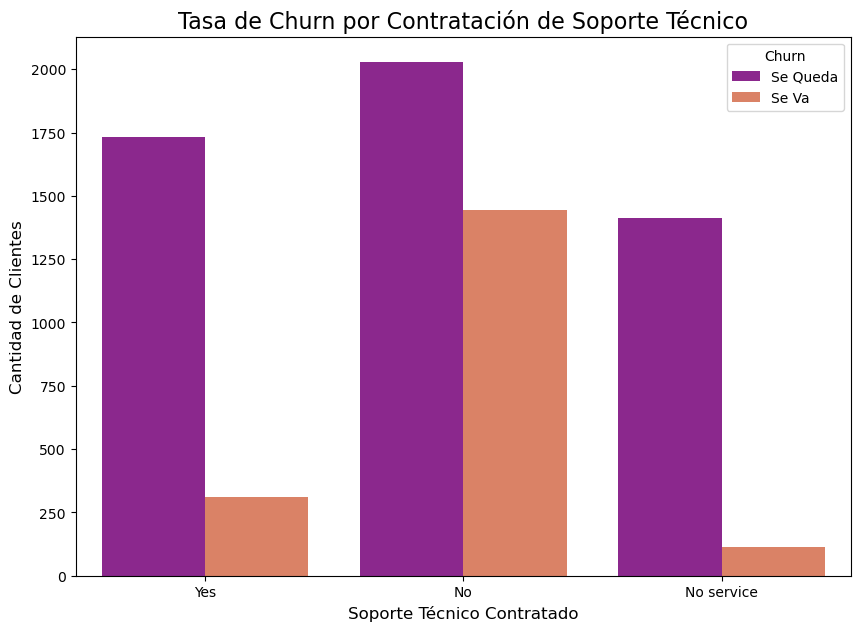

In [35]:
# --- Celda EDA: Churn vs. Soporte Técnico ---

plt.figure(figsize=(10, 7))
sns.countplot(x='TechSupport', hue='Churn', data=df_model, palette='plasma')
plt.title('Tasa de Churn por Contratación de Soporte Técnico', fontsize=16)
plt.xlabel('Soporte Técnico Contratado', fontsize=12)
plt.ylabel('Cantidad de Clientes', fontsize=12)
plt.legend(title='Churn', labels=['Se Queda', 'Se Va'])
plt.show()

Los clientes que no tienen soporte técnico (No) se van en una proporción mucho mayor que aquellos que sí lo tienen. Esto demuestra el valor del servicio de soporte para la retención de clientes. 

## Preprocesamiento de datos

In [38]:
# Preprocesamiento y División de Datos

# 1. Separar features (X) y target (y)
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

# 2. Identificar columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 3. Crear un transformador para preprocesar la información 
# Las columnas se vuelven numéricas y en una escala comparable para ser usadas por los modelos.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 4. Dividir los datos en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Datos divididos en entrenamiento y prueba.")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Datos divididos en entrenamiento y prueba.
Forma de X_train: (5634, 17)
Forma de X_test: (1409, 17)


## Dummy Classifier

In [42]:
# Prueba de Cordura con Dummy Classifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)

# Realizar predicciones
y_pred_dummy = dummy_clf.predict(X_test)
# NUEVO: Predecir probabilidades para ROC-AUC
y_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1]

# Calcular las métricas
acc_dummy = accuracy_score(y_test, y_pred_dummy)
f1_dummy = f1_score(y_test, y_pred_dummy, zero_division=0)
roc_auc_dummy = roc_auc_score(y_test, y_proba_dummy)

print("Reporte del Dummy Classifier:")
print(f"Accuracy: {acc_dummy:.3f}")
print(f"F1-Score: {f1_dummy:.3f}")
print(f"ROC-AUC Score: {roc_auc_dummy:.3f}\n")

print("Reporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred_dummy, zero_division=0))

Reporte del Dummy Classifier:
Accuracy: 0.735
F1-Score: 0.000
ROC-AUC Score: 0.500

Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409



Del Dummy Classifier se puede observar lo siguiente: 

- La **Accuracy (Exactitud)** es alta con **0.735**, esto significa que el modelo siempre predice a la clase mayoritaria (los "No Churn"), y como el 73.5% de los clientes no se van, acierta el 73.5% de las veces. Esto demuestra que la exactitud no es una buena métrica en este caso.

- El **F1-score es 0.00**. Esto es porque el modelo siempre predice a los "0" (No Churn) y nunca acierta a los que sí se van ("1"). 

- **El ROC-AUC Score es de 0.5**, lo que representa un modelo sin ninguna capacidad para distinguir entre las clases, es decir, es equivalente a adivinar al azar. 

Con este punto de partida, los modelos a desarrollar serán **mucho mejores** que lo hecho por el Dummy Classifier.

## Balanceo de clases

Antes de entrenar los modelos, se aplicará SMOTE sobre el conjunto de entrenamiento para crear datos sintéticos de la clase minoritaria (clientes que sí se fueron).

In [49]:
# Balanceo de clases con SMOTE 

# Se aplica el preprocesamiento a los datos de entrenamiento
X_train_processed = preprocessor.fit_transform(X_train)

# Se aplica SMOTE solo a los datos de entrenamiento ya procesados
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print("Dimensiones antes de SMOTE:", X_train_processed.shape)
print("Dimensiones después de SMOTE:", X_train_smote.shape)
print("\nDistribución de clases después de SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Procesar los datos de prueba (sin aplicar SMOTE)
X_test_processed = preprocessor.transform(X_test)

Dimensiones antes de SMOTE: (5634, 42)
Dimensiones después de SMOTE: (8278, 42)

Distribución de clases después de SMOTE:
Churn
0    4139
1    4139
Name: count, dtype: int64


## Modelos

Se aplicarán 3 modelos:
1. **Regresión Logística**: Es simple, rápido e interpretable.
2. **Random Forest**: Combina múltiples árboles de decisión.
3. **Gradient Boosting**: Construye los árboles de decisión de forma secuencial, donde cada nuevo árbol intenta corregir los errores del anterior.

In [64]:
# Modelo 1 - Regresión Logística

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_smote, y_train_smote)

# Predicciones en Entrenamiento 
y_pred_train_lr = log_reg.predict(X_train_smote)
y_proba_train_lr = log_reg.predict_proba(X_train_smote)[:, 1]

# Predicciones en Prueba
y_pred_test_lr = log_reg.predict(X_test_processed)
y_proba_test_lr = log_reg.predict_proba(X_test_processed)[:, 1]

# Métricas de Entrenamiento
f1_train_lr = f1_score(y_train_smote, y_pred_train_lr)
roc_auc_train_lr = roc_auc_score(y_train_smote, y_proba_train_lr)

# Métricas de Prueba 
f1_test_lr = f1_score(y_test, y_pred_test_lr)
roc_auc_test_lr = roc_auc_score(y_test, y_proba_test_lr)

print("Evaluación de Regresión Logística:")
print(f"F1-Score (Entrenamiento): {f1_train_lr:.3f}")
print(f"F1-Score (Prueba): {f1_test_lr:.3f}\n")
print(f"ROC-AUC (Entrenamiento): {roc_auc_train_lr:.3f}")
print(f"ROC-AUC (Prueba): {roc_auc_test_lr:.3f}\n")
print("Reporte de Clasificación en Prueba:")
print(classification_report(y_test, y_pred_test_lr))

Evaluación de Regresión Logística:
F1-Score (Entrenamiento): 0.777
F1-Score (Prueba): 0.618

ROC-AUC (Entrenamiento): 0.852
ROC-AUC (Prueba): 0.834

Reporte de Clasificación en Prueba:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.75      0.76      1409



In [66]:
# Modelo 2 - Random Forest

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_smote, y_train_smote)

# Predicciones en Entrenamiento
y_pred_train_rf = rf_clf.predict(X_train_smote)
y_proba_train_rf = rf_clf.predict_proba(X_train_smote)[:, 1]

# Predicciones en Prueba 
y_pred_test_rf = rf_clf.predict(X_test_processed)
y_proba_test_rf = rf_clf.predict_proba(X_test_processed)[:, 1]

# Métricas de Entrenamiento
f1_train_rf = f1_score(y_train_smote, y_pred_train_rf)
roc_auc_train_rf = roc_auc_score(y_train_smote, y_proba_train_rf)

# Métricas de Prueba 
f1_test_rf = f1_score(y_test, y_pred_test_rf)
roc_auc_test_rf = roc_auc_score(y_test, y_proba_test_rf)

print("Evaluación de Random Forest:")
print(f"F1-Score (Entrenamiento): {f1_train_rf:.3f}")
print(f"F1-Score (Prueba): {f1_test_rf:.3f}\n")
print(f"ROC-AUC (Entrenamiento): {roc_auc_train_rf:.3f}")
print(f"ROC-AUC (Prueba): {roc_auc_test_rf:.3f}\n")
print("Reporte de Clasificación en Prueba:")
print(classification_report(y_test, y_pred_test_rf))

Evaluación de Random Forest:
F1-Score (Entrenamiento): 0.998
F1-Score (Prueba): 0.566

ROC-AUC (Entrenamiento): 1.000
ROC-AUC (Prueba): 0.814

Reporte de Clasificación en Prueba:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1035
           1       0.58      0.55      0.57       374

    accuracy                           0.78      1409
   macro avg       0.71      0.70      0.71      1409
weighted avg       0.77      0.78      0.77      1409



In [68]:
# Modelo 3 - Gradient Boosting

gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train_smote, y_train_smote)

# Predicciones en Entrenamiento
y_pred_train_gb = gb_clf.predict(X_train_smote)
y_proba_train_gb = gb_clf.predict_proba(X_train_smote)[:, 1]

# Predicciones en Prueba
y_pred_test_gb = gb_clf.predict(X_test_processed)
y_proba_test_gb = gb_clf.predict_proba(X_test_processed)[:, 1]

# Métricas de Entrenamiento
f1_train_gb = f1_score(y_train_smote, y_pred_train_gb)
roc_auc_train_gb = roc_auc_score(y_train_smote, y_proba_train_gb)

# Métricas de Prueba
f1_test_gb = f1_score(y_test, y_pred_test_gb)
roc_auc_test_gb = roc_auc_score(y_test, y_proba_test_gb)

print("Evaluación de Gradient Boosting:")
print(f"F1-Score (Entrenamiento): {f1_train_gb:.3f}")
print(f"F1-Score (Prueba): {f1_test_gb:.3f}\n")
print(f"ROC-AUC (Entrenamiento): {roc_auc_train_gb:.3f}")
print(f"ROC-AUC (Prueba): {roc_auc_test_gb:.3f}\n")
print("Reporte de Clasificación en Prueba:")
print(classification_report(y_test, y_pred_test_gb))

Evaluación de Gradient Boosting:
F1-Score (Entrenamiento): 0.860
F1-Score (Prueba): 0.621

ROC-AUC (Entrenamiento): 0.936
ROC-AUC (Prueba): 0.844

Reporte de Clasificación en Prueba:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1035
           1       0.57      0.69      0.62       374

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.78      0.78      1409



## Resumen de modelos

Se comparan los **resultados de los modelos**, tanto de **'Prueba'** como de **'Entrenamiento'**, para saber si se puede confiar en los modelos. Esto ya que, a pesar de que el puntaje más importante para seleccionar al mejor modelo es el de Prueba (Test), que dice cómo se comportará el modelo en el futuro, el puntaje de Entrenamiento (Train) es indispensable para saber si el modelo aprendió bien los patrones y es capaz de aplicarlos a nuevos datos, o si sólo se memorizó el comportamiento de los datos.

In [72]:
# Resumen y Conclusión final de los modelos

# Se crea un DataFrame para comparar los resultados de 'Prueba' y de 'Entrenamiento'
results_df = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'Random Forest', 'Gradient Boosting'],
    'F1-Score (Prueba)': [f1_test_lr, f1_test_rf, f1_test_gb],
    'ROC-AUC (Prueba)': [roc_auc_test_lr, roc_auc_test_rf, roc_auc_test_gb],
    'F1-Score (Entrenamiento)': [f1_train_lr, f1_train_rf, f1_train_gb],
    'ROC-AUC (Entrenamiento)': [roc_auc_train_lr, roc_auc_train_rf, roc_auc_train_gb]
})

# Se formatean los valores para mejor lectura
results_df = results_df.round(3)

print("Comparación de Modelos:")
display(results_df)

print("\n Conclusión:")
best_f1_model = results_df.sort_values(by='F1-Score (Prueba)', ascending=False).iloc[0]
print(f"El mejor modelo basado en F1-Score de prueba es: \n{best_f1_model}")

Comparación de Modelos:


,Modelo,F1-Score (Prueba),ROC-AUC (Prueba),F1-Score (Entrenamiento),ROC-AUC (Entrenamiento)
0,Regresión Logística,0.618,0.834,0.777,0.852
1,Random Forest,0.566,0.814,0.998,1.000
2,Gradient Boosting,0.621,0.844,0.860,0.936



 Conclusión:
El mejor modelo basado en F1-Score de prueba es: 
Modelo                      Gradient Boosting
F1-Score (Prueba)                       0.621
ROC-AUC (Prueba)                        0.844
F1-Score (Entrenamiento)                 0.86
ROC-AUC (Entrenamiento)                 0.936
Name: 2, dtype: object


## Conclusión Final

El mejor modelo fue **Gradient Boosting** con excelentes resultados en las métricas de su capacidad de predicción:

- ROC-AUC: 0.844
- F1-Score: 0.621

En el caso del Random Forest, que tuvo un F1-Score de 0.998 en train pero solo 0.566 en prueba, indica un cierto grado de 'sobreajuste' u 'Overfitting', ya que el puntaje de Entrenamiento fue mucho más alto que el de la Prueba.